In [1]:
import os
import sys
from sqlalchemy import Column, ForeignKey, Integer, CHAR, Date, String, Time, Index, DateTime, TIMESTAMP, func, or_
from sqlalchemy.dialects.mysql import INTEGER, BIT, TINYINT, TIME, DOUBLE, TEXT,TIMESTAMP
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship
from sqlalchemy import create_engine
from sqlalchemy import PrimaryKeyConstraint
from sqlalchemy.orm import sessionmaker
server = 'Your AWS address'
connection_string = 'mysql+mysqldb://root:MYSQLPassword@{}:3306/findas'.format(server)
engine = create_engine(connection_string, pool_recycle = 3600, encoding='utf-8')

Base = declarative_base()

class rent(Base):
    __tablename__ = 'rent'
    idandtype = Column(String(15), primary_key = True, nullable = False, autoincrement = False)
    productname = Column(String(50), nullable= False, default = None)
    interest_type = Column(String(20),nullable = False, default = None)
    company = Column(String(50), nullable= False, default = None)
    lowest_rate = Column(DOUBLE, nullable= False, default = None)
    highest_rate = Column(DOUBLE, nullable= False, default = None)
    last_month_interest = Column(DOUBLE, nullable = True, default = None )
    maximum_period = Column(INTEGER, nullable = True, default = None )
    preference = Column(TEXT, nullable = True, default = None)
    redemption_fee = Column(TEXT, nullable = True, default = None)
    related_fee = Column(TEXT, nullable = True, default = None)
    review_counts = Column(INTEGER, nullable = False, default = 0)
    average_rate = Column(DOUBLE, nullable = True, default = None)
    

class reviews(Base):
    __tablename__ = 'reviews'
    reviewid = Column(INTEGER, nullable = False, autoincrement = True, primary_key = True)
    date = Column(String(15), nullable = False, autoincrement = False, primary_key = False)
    idandtype = Column(String(15), nullable = False, autoincrement = False)
    total_rating = Column(DOUBLE,nullable = False, default = None)
    interest_sat = Column(INTEGER,nullable = False, default = None)
    online_sat = Column(INTEGER, nullable = False, default = None)
    prof_sat = Column(INTEGER, nullable = False, default = None)
    service_sat = Column(INTEGER, nullable = False, default = None)
    review = Column(TEXT,nullable = True, default = None)
    

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 주택담보대출 & 전월세 대출 상품 분석을 통한 전략제시
* 데이터 product id가 다르더라도 같은 상품이 중복되어 나타나는 경우가 존재. 이를 제거하고 중복되지 않는 상품만 rent_df에 불러옴
* 핀다에서 주택담보대출과 전월세 대출 상품의 경우  사용자들의 리뷰를 금융 기관을 기준으로 분류되어 있으므로 같은 회사의 제품이면 평가가 동일 
* 총 212개의 주택담보대출 상품 중 75개의 상품의 전월 평균 금리를 0%라고 표현하고 있음
* 전월 평균 금리를 표시한 주택담보대출 상품의 경우 평균적으로 4.91%의 전월평균 금리를 나타냄


In [3]:
df = pd.read_sql('''select * from(select * from rent order by productname,company,idandtype desc ) rentsc group by productname,company''',engine)
mort_df = df.ix[df['idandtype'].apply(lambda x : 'MORT' in x),:]
rent_df = df.ix[df['idandtype'].apply(lambda x : 'RENT' in x),:]
# mort_df = pd.read_csv('mort_df.csv')
print '대출 금리를 0%라고 표시한 주택담보대출 상품의 개수',sum(mort_df['last_month_interest']==0)
print '\n주택담보대출 상품\n', mort_df[mort_df['last_month_interest']!=0][['lowest_rate','highest_rate','last_month_interest']].describe()


대출 금리를 0%라고 표시한 주택담보대출 상품의 개수 75

주택담보대출 상품
       lowest_rate  highest_rate  last_month_interest
count   141.000000    141.000000           141.000000
mean      4.011418      7.438582             4.910709
std       1.318450      4.083306             2.086082
min       0.000000      0.000000             2.640000
25%       3.030000      4.460000             3.300000
50%       3.560000      5.710000             3.880000
75%       4.800000      9.350000             6.450000
max       8.000000     23.000000            15.000000


* 상품 분류를 위한 KMeans 알고리즘 사용
    * 주택 담보 대출 상품의 분류를 위해 K-means 알고리즘을 사용하여 전체 상품을 총 7가지 상품으로 분류해본다. 

In [14]:
from sklearn.cluster import KMeans
model = KMeans(init="k-means++", n_clusters=7, random_state=42,max_iter = 600).fit(mort_df[['lowest_rate','highest_rate','last_month_interest']])
mort_df['cluster'] = model.predict(mort_df[['lowest_rate','highest_rate','last_month_interest']])
X = np.asarray(mort_df[['lowest_rate','highest_rate','last_month_interest','cluster']])


c:\python27\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


* 첫 번째 클러스터에는 전월 평균 금리가 5 % 를 넘지 않는 중저 금리 상품, 두번째 클러스터에는 상품의 금리가 정확히 기재되지 않는(0%로 표시된)  상품들이 나탄난것을 확인할 수 있다. 
* 이와 같은 방식으로 각각의 클러스터에는 다음과 같은 특징이 나타난다. 
    * cluster 0 : 최저 금리 2~3% 전월 평균 금리 2~4%의 저금리 상품
    * cluster 1 : 금리 정보가 표시되지 않는 제 1금융권 상품
    * cluster 2 : 전월 평균금리 6~10% 최고금리 10% 이상 15% 미만의  고정금리 제 2금융권 주택담보대출 상품
    * cluster 3 : 전월 평균금리 6~10% 최고금리 10% 미만의 제2금융권 상품
    * cluster 4 : 최고 금리 15% 이상의 전월 평균금리 8% 이상의 제 2금융권 상품
    * cluser 5 :  최저 금리 2~3% 이고 전월 평균 금리가 표시되지 않는 상품
    * cluster 6 : 전월 평균 금리가 4~7% 수준으로 나타나지만 최고 금리가 15%이상의 제2 금융권 상품들

In [358]:
def decode_txt(strs):
    try:
        return strs.decode('utf-8')
    except:
        return strs
print tabulate(mort_df[mort_df.cluster == 0].applymap(decode_txt)[['productname','interest_type','company','lowest_rate','highest_rate',
                                            'last_month_interest']].head(20),
               headers= [u'제품명',u'금리종류',u'기업',u'최저',u'최고',u'전월평균'], tablefmt='psql')

print tabulate(mort_df[mort_df.cluster == 1].applymap(decode_txt)[['productname','interest_type','company','lowest_rate','highest_rate',
                                            'last_month_interest']].head(20),
               headers= [u'제품명',u'금리종류',u'기업',u'최저',u'최고',u'전월평균'], tablefmt='psql')



+----+-----------------------------------+------------+------------+--------+--------+------------+
|    | 제품명                            | 금리종류   | 기업       |   최저 |   최고 |   전월평균 |
|----+-----------------------------------+------------+------------+--------+--------+------------|
|  6 | 6개월 변동금리 - APT론            | 변동       | star_sb    |   3.1  |   7.2  |       4.2  |
| 10 | BNK357금리안심모기지론            | 고정       | bnkbs      |   3.4  |   4.96 |       3.4  |
| 11 | BNK금리상한 모기지론              | 변동       | bnkbs      |   3.01 |   5.37 |       3.26 |
| 13 | BNK행복스케치 모기지론            | 변동       | bnkbs      |   3.11 |   5.67 |       4.35 |
| 14 | DGB HYBRID 모기지론(구입)         | 고정       | dgb        |   3.03 |   5.5  |       3.16 |
| 15 | DGB HYBRID 모기지론(생활)         | 고정       | dgb        |   3.03 |   5.24 |       3.15 |
| 16 | DGB 장기모기지론(구입)            | 변동       | dgb        |   2.85 |   5.5  |       2.81 |
| 17 | DGB 장기모기지론(생활)            | 변동       | dgb        |   2.85 |   5.25 |       

* 클러스터된 상품의 분포를 나타낸 그래프

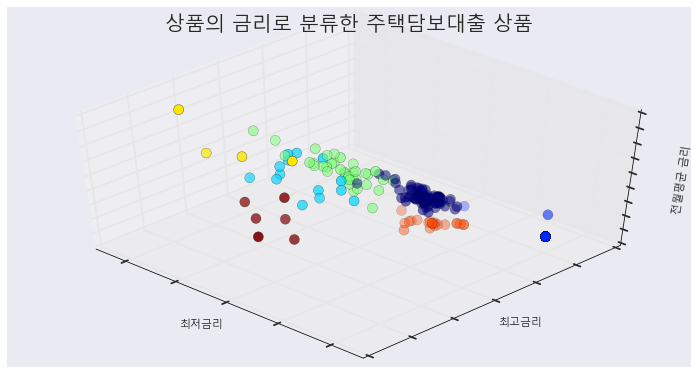

In [22]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
fig = plt.figure(figsize = (10,5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()
labels = model.labels_
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels.astype(np.float), s=100, cmap=mpl.cm.jet,)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('최저금리'.decode('utf-8'))
ax.set_ylabel('최고금리'.decode('utf-8'))
ax.set_zlabel('전월평균 금리'.decode('utf-8'))
plt.title('상품의 금리로 분류한 주택담보대출 상품'.decode('utf-8'),fontsize = 20)


* 주택 담보대출 상품의 총 리뷰 분석
    * 주택 담보 대출 상품의 경우 우리은행의 상품이 23개로 가장 많이 게재되었고 그뒤를 신한은행, KB국민은행, KEB하나은행 순으로 게재되어있다.
    * KB국민은행의 상품들이 47개의 리뷰를 받으면서 가장 많은 리뷰를 받고있고 그뒤를 우리은행, 농협은행의 상품들이 뒤따르고 있다. 
    * 농협은행은 상품 수 대비 가장 높은 리뷰를 받고있는 것으로 나타남
    * 총 68개의 기업의 주택담보대출 상품들이 리뷰를 받은적이 없는 것으로 나타남  

상품 리뷰를 받지 못한 주택담보대출 상품 68
AJU_SB , INCHEON_SB , JI_SB , YEGARAM_SB , JTCHINAE_SB , KB_SB , KDB , KDB_LIFE , KUKJE_SB , NH_FIRE , NH_LIFE , NH_SB , OK_SB , OSB_SB , OSUNG_SB , PEPPER_SB , PUREUN_SB , SAMHO_SB , SBI_SB , SHINAN_SB , SHINHAN_LIFE , SHINHAN_SB , SJ_SB , SMART_SB , SOULBRAIN_SB , STAR_SB , THEK_SB , TS_SB , UNION_SB , YC_SB , HYUNDAI_SB , HK_SB , JINJU_SB , YJ_SB , CHEONGJU_SB , BULIM_SB , DAEA_SB , DAEHAN_SB , DAEWON_SB , DAISHIN_SB , DH_SB , DM_SB , CH_SB , ASAN_SB , GANGWON_SB , ANYANG_SB , GUMI_SB , CENTRAL_SB , ANGUK_SB , HANA_SB , ALLIANZ_LIFE , GORYO_SB , HYUNDAI_LIFE , SERAM_SB , DEBEC_SB , DREAM_SB , HANSUNG_SB , PT_SB , IBK_SB , SAMSUNG_FIRE , KI_SB , BNKGN , DONGBU_INS , HEUNGKUK_FIRE , KB_INS , HEUNGKUK_LIFE , HANWHA_INS , KYOBO_LIFE ,


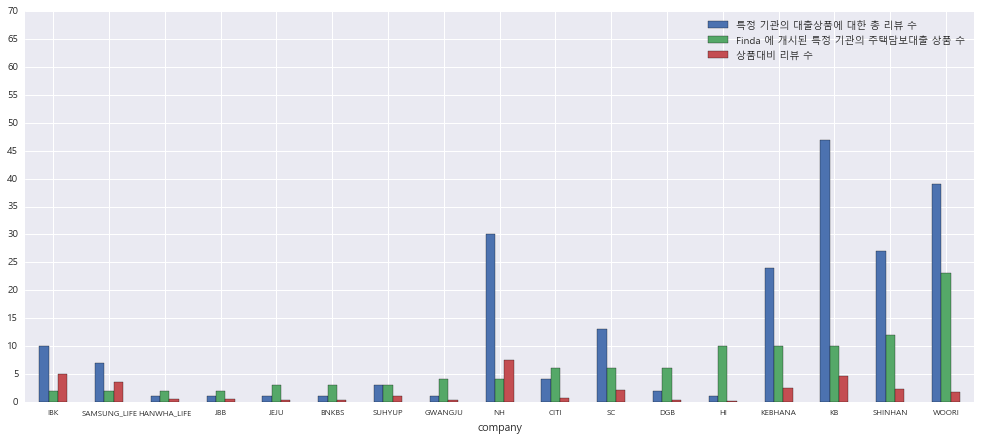

In [352]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

mort_grouped = mort_df.groupby('company')
productcounts = mort_grouped.agg({'productname': pd.Series.nunique,'review_counts': np.mean})
productcounts['상품대비 리뷰 수 '] = productcounts['review_counts'] / productcounts['productname']
productcounts.rename(columns={'productname': 'Finda 에 개시된 특정 기관의 주택담보대출 상품 수','review_counts':'특정 기관의 대출상품에 대한 총 리뷰 수'}, inplace=True)
productcounts.reset_index(inplace= True)
productcounts['company'] = productcounts['company'].apply(lambda x: x.upper())
productcounts.sort_values('Finda 에 개시된 특정 기관의 주택담보대출 상품 수',inplace = True)
productcounts[productcounts['특정 기관의 대출상품에 대한 총 리뷰 수'] > 0].plot(x = 'company',kind = 'bar',figsize = (17,7),yticks = (np.arange(0,15)*5),style = True,)
plt.xticks(fontsize = 8,rotation = 0)
print '상품 리뷰를 받지 못한 주택담보대출 상품',len(list(productcounts[productcounts['특정 기관의 대출상품에 대한 총 리뷰 수'] == 0]['company']))
for notreviewd in list(productcounts[productcounts['특정 기관의 대출상품에 대한 총 리뷰 수'] == 0]['company']):
    print notreviewd,',',

* 리뷰를 받은 상품과 리뷰를 받지 못한 전월 평균 금리를 비교해 보면 리뷰를 받은 상품의 전월 평균 금리는 대게 0%로 나타난다. 이는 실제 금리가 0%라는 의미가 아니라 정보를 공개하지 않은 것

* 전월 평균금리 5%이상의 고금리 주택담보대출 상품에는 사용자들의 평가가 존재하지 않음
    * 현재 핀다사이트 이용고객이 대게 은행권 대출 가능고객들로 이루어진것을 확인 할 수 있음
    * 대출 조건 검색 시 제 1금융권 검색을 우선으로 설정한 핀다 사이트의 특성과도 연관 있음 

c:\python27\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


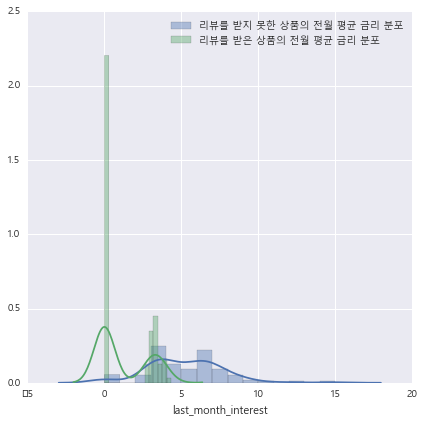

In [142]:
mort_df['reviewed'] =  mort_df['review_counts'] > 0
sns.FacetGrid(mort_df, hue = 'reviewed',size = 6).map(sns.distplot,'last_month_interest',bins = 15)
L=plt.legend()
L.get_texts()[0].set_text(u'리뷰를 받지 못한 상품의 전월 평균 금리 분포')
L.get_texts()[1].set_text(u'리뷰를 받은 상품의 전월 평균 금리 분포')


* 주택담보대출 상품의 댓글 분석
    * 각 기업의 상품에는 같은 댓글이 달려있으므로 기업별로 하나의 상품만을 선정하여 댓글을 가져오면 된다. 

In [7]:
representative = tuple(mort_df.groupby('company').first()['idandtype'])#각각의 기업별 상품의 id가 하나씩 선택된 tuple
mort_reviews = pd.read_sql('select * from reviews where idandtype in {} '.format(representative),engine)
mort_com = mort_df.groupby('company').first()[['idandtype','review_counts']].reset_index()
mort_reviews = pd.merge(mort_com,mort_reviews,on = 'idandtype')

* 5개이상의 리뷰를 기록한 상품들 중에서 삼성생명의 상품들이 가장 높은 총점을 기록했다. 특히 가장 높은 서비스 만족도를 기록하면서 좋은성과를 보여주었다. 
* KB 국민은행의 경우에는 온라인 대응 부분에서 좋지 않은 평가를 받으면서 가장 낮은 평점을 기록했다.  

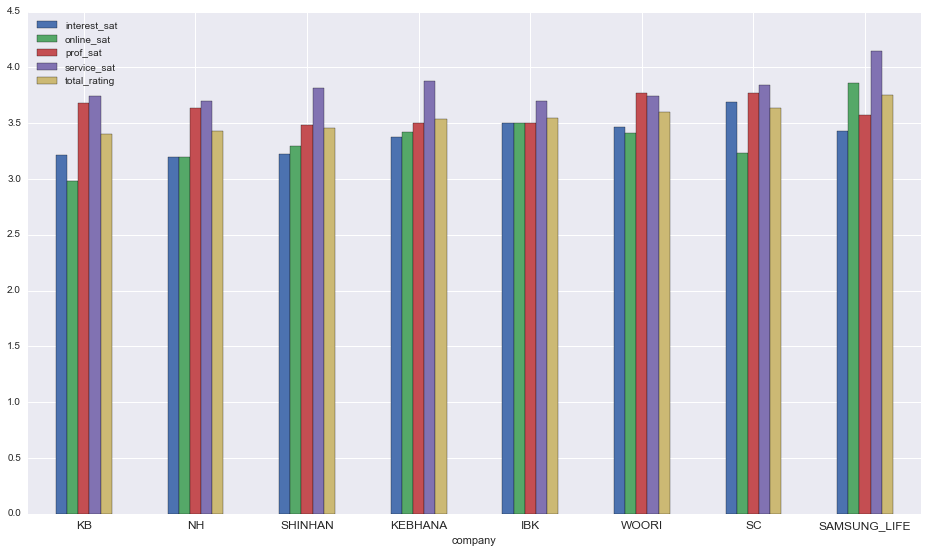

In [8]:
mort_reviews['company'] = mort_reviews['company'].apply(lambda x: x.upper())
mort_reviews[mort_reviews.review_counts > 5].groupby('company').mean().sort_values('total_rating')[['interest_sat','online_sat','prof_sat','service_sat','total_rating']].plot(kind = 'bar',figsize = (16,9),style = True)
plt.xticks(fontsize = 12,rotation = 0)
plt.legend(loc = 2)

* 국민은행의 상품에 대해 낮은 온라인 편의성 점수를 부여한 리뷰를 분석:
    * 온라인 편의성에 대한 직접적인 불만을 나타낸 댓글은 많지 않지만 본사 사이트에 소개한 상품이 실제로 취급되지 않는 경우가 많다는 댓글이 있고 고객들 모두 오프라인 상담의 친절성을 주로 언급한 반면 온라인 서비스에 대한 언급은 없음

In [43]:
kb = mort_reviews[(mort_reviews.company == 'KB') & (mort_reviews.online_sat < 3)]
for kbreview,online_sat in zip(kb['review'],kb['online_sat']):
    print '온라인편의성 평점:',online_sat,'\n','댓글 내용:',kbreview,'\n'

온라인편의성 평점: 2 
댓글 내용: 집을 구입하면서 대출이 필요했습니다. 인터넷을 찾아보니 70%까지 가능하다는 말도 있었고, 최대는 90%까지 가능하다는 말도 있었습니다.  지금 살고 있는 보증금과 새로 이사갈 집의 금액이 맞지 않아 대출이 최대한 필요했습니다. 주거래 은행이었던 국민은행을 방문했고, 상담과정은 무난했습니다. 아파트 구입금액/ 제 앞에 대출이 있는 지/ 마지막으로 연봉 등에 대해 물어봤습니다. 정확한 소득자료 검토 후에  대출을 무난히 받을 수 있었습니다. 하지만 금리가 다른 은행과 비교 했을 때, 제가 잘 받았는 지 판단이 명확하게 안되는 점은 조금 아쉬웠습니다. 그래도 대체적으로 만족하며 상환을 하고 있습니다.  

온라인편의성 평점: 2 
댓글 내용: 금리가 너무 높지도 않고 적당하게 받은 거 같아 만족스럽다, 단점은 대출 외의 서비스에 대해서 전반적으로 불만족스럽다 

온라인편의성 평점: 1 
댓글 내용: 가장 적합한 상품을 추천해줌. 다만, 본사 사이트에 소개된 상품조차 취급하지 않는 게 있었음, 단점은 창구 문의시 본사 사이트에 소개된 상품이 없고, 내겐 큰 금액이지만 은행으로서는 작은 금액이어서인지 대충 끝내려는 느끼이 강했음. 금리 높을 때는 3년간 미변동금리더니, 지금 금리가 낮아져 다른 상품 갈아탔더니 1년마다 갱신이어서 황당 

온라인편의성 평점: 2 
댓글 내용: 지점이 많은곳에 있어 방문이 편리하다. 어플이 사용하기 편리하게 되어있다, 단점은 1금융권 중에서는 대출금리가 높은 편이다. 장기우수고객에 대한 서비스나 혜택이 부족하다 

온라인편의성 평점: 2 
댓글 내용: 주거래은행이라 주택담보대출 받았음 그런데 상담 및 가입 시 정보 제공이 미흡함. 이해를 많이 못함 

온라인편의성 평점: 2 
댓글 내용: 1년전 갑자기 집을 구매하게되었는데 자금이부족하여 대출을 하게됬습니다 신중히고르다 국민은행에서 소득7천이하면 기금대출이가능하다고하여  받았는데 금리도 타은행권보다 낮았고 추가로 청약및상환기간에따라 할인을 더받을수있었

* 삼성 생명의 주택담보대출 상품의 댓글을 분석해본 결과  서비스 점수에 높은 점수를 부여한  분석해본 결과 전반적으로 까다롭지 않는 진행절차와 중도 상환 수수료상의 장점등을 나타내고 있음

In [377]:
samsung = mort_reviews[(mort_reviews.company == 'samsung_life') ]
for samsungreview,service_sat in zip(samsung['review'],samsung['service_sat']):
    print '서비스 만족도 평점:',service_sat,'\n','댓글 내용:',samsungreview,'\n'

서비스 만족도 평점: 5 
댓글 내용: 작년 지인 소개로 저렴한 이자가 있다고 해서

삼성생명으로 주택 담보대출 전환대출을 받았는데요 다른 추가 상품 구매없이 우대 금리 받아서 기쁘네요

창구 직원분들도 친절하시고 콜센터 응대도 좋구요  

서비스 만족도 평점: 4 
댓글 내용: 집주인이 작년 12월경 전세집을 비워달라고 해서 급하게 집을 매매하면서 대출을 알아보게 되었습니다.  여러은행하고 비교해보니 은행은 은행카드를 사용해서 실적이 있어야하는 등 조건이 까다로웠는데, 급하게 준비하는 거라  이러한 부가조건이 없는 삼성생명 대출을 이용하게 됐습니다.  담당하시는 분이  상환기간이라든가  대출금리 줄어드는 내용이라든지  자세히 알려주시고 문서도 꼼꼼히 챙길수 있도록 도와주셔서 편했어요. 상담받아보시면 좋으실꺼 같아요 

서비스 만족도 평점: 5 
댓글 내용: 결혼을 하게되어서 아파트 구입차 태어나서 처음을 주택담보대출이란걸 받아보게 되었습니다. 집에서 지원해준돈과 대출을 받을 돈으로 해결해야하는 상황에서 입금기한을 맞추려고 좀 빠듯하게 진행하게 되었었는데 복잡할것이라는 우려와 달리 절차도 생각보다 간단하였고 상담사분이 제가 사는 지역까지 찾아와주시는 수고를 해주시는 덕분에 편하게 대출을 받을수 있었습니다. 그리고 상환방법이라던가 금리변동 그리고 중도상환에 대한 설명도 자세히 해주어서 이해하기가 쉬웠고 또한 약간이긴 하지만  금리를 낮추는 좋은방법도 친절하게 설명해주어서 어렵지않게 적당히 낮은 금리로 쉽게 대출을  받을수 있어서 좋았습니다.  

서비스 만족도 평점: 2 
댓글 내용: 전세로 살다가 생애 처음으로 갖게된 우리집.. 그러나 주택구입비용이 모자랐던차에 가입해둔 보험이었던 삼성생명을 알아보게 되었는데 나에게는 1금융권의 은행담보대출보다 더 좋은 조건과 더 좋은 금리로 대출을 할수있었습니다. 직원이 대출 받기에 새로운 상품가입에 대한 압박을 준것도 없고 해서 아주 편하게 대출을 받게 되었습니다. 

서비스 만족도 평점: 4 
댓글 내용: 주택매매 계약을

# 전월세대출 분석
* 전월세 상품의 경우 총 62개의 상품 중에서 35개의 상품이 대출금리를 정확하게 명시하지 않고 있음 
* 전월세 상품의 경우 평균적으로 4.76%의 전월 평균 금리를 나타내고 있음

In [369]:
rent_df = df.ix[df['idandtype'].apply(lambda x : 'RENT' in x),:]
# rent_df = pd.read_csv('rent_df.csv',encoding = 'utf-8') 로 대신 실행 가능
print '대출 금리를 0%라고 표시한 전월세 대출 상품의 개수',sum(rent_df['last_month_interest']==0)
print '\n전월세 대출 상품\n', rent_df[rent_df['last_month_interest']!=0][['lowest_rate','highest_rate','last_month_interest']].describe()

대출 금리를 0%라고 표시한 전월세 대출 상품의 개수 35

전월세 대출 상품
       lowest_rate  highest_rate  last_month_interest
count    62.000000     62.000000            62.000000
mean      3.908226      6.827742             4.769355
std       1.520256      4.439500             2.465968
min       2.520000      3.150000             2.620000
25%       2.902500      4.320000             3.137500
50%       3.430000      5.300000             3.665000
75%       4.327500      7.775000             6.150000
max       9.400000     25.000000            16.000000


* 핀다사이트에는 게재된 전월세 대출 상품 중에서 우리은행의 상품이 13개로 가장 많이 게재되있고 kb와 신한은행의 상품이 각각 10개씩 게재되어 있음
* 리뷰 역시 우리은행의 상품군에 69개로 가장 많은 리뷰가 이루어졌고 이를 신한은행, KB국민은행 순으로 따르고 있음

상품 리뷰를 받지 못한 주택담보대출 상품 31
ALLIANZ_LIFE , INSUNG_SB , JINJU_SB , KI_SB , KIWOOM_SB , KYOBO_LIFE , LOTTE_INS , HYUNDAI_SB , MOA_SB , SAMHO_SB , SAMSUNG_FIRE , SAMSUNG_LIFE , SHINHAN_LIFE , SMART_SB , SOULBRAIN_SB , MYANGEL , HK_SB , HEUNGKUK_LIFE , ASAN_SB , BULIM_SB , CHEONGJU_SB , DAEHAN_SB , DY_SB , GUMI_SB , YEGARAM_SB , HEUNGKUK_FIRE , GORYO_SB , DGB , HI , DONGBU_INS , CITI ,


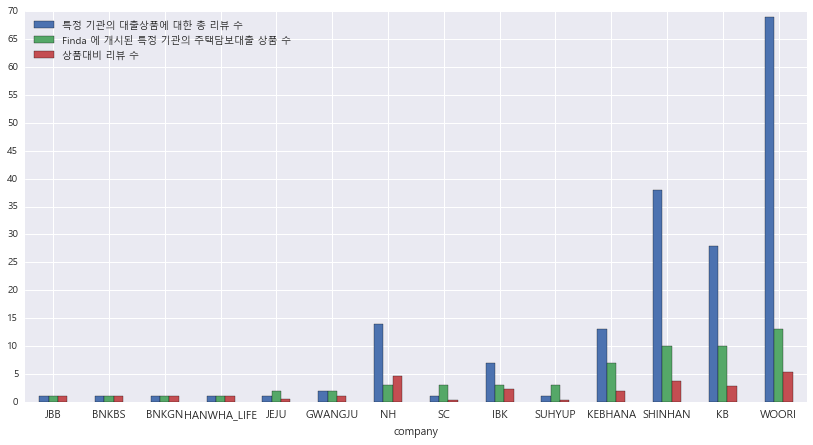

In [374]:
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib as mpl
%matplotlib inline
from matplotlib import font_manager, rc
rent_grouped = rent_df.groupby('company')
productcounts = rent_grouped.agg({'productname': pd.Series.nunique,'review_counts': np.mean})
productcounts['상품대비 리뷰 수 '] = productcounts['review_counts'] / productcounts['productname']
productcounts.rename(columns={'productname': 'Finda 에 개시된 특정 기관의 주택담보대출 상품 수','review_counts':'특정 기관의 대출상품에 대한 총 리뷰 수'}, inplace=True)
productcounts.reset_index(inplace= True)
productcounts['company'] = productcounts['company'].apply(lambda x: x.upper())
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
productcounts.sort_values('Finda 에 개시된 특정 기관의 주택담보대출 상품 수',inplace = True)
productcounts[productcounts['특정 기관의 대출상품에 대한 총 리뷰 수'] > 0].plot(x = 'company',kind = 'bar',figsize = (14,7),yticks = (np.arange(0,15)*5),style = True,)
plt.xticks(fontsize = 11,rotation = 0)
print '상품 리뷰를 받지 못한 주택담보대출 상품',len(list(productcounts[productcounts['특정 기관의 대출상품에 대한 총 리뷰 수'] == 0]['company']))
for notreviewd in list(productcounts[productcounts['특정 기관의 대출상품에 대한 총 리뷰 수'] == 0]['company']):
    print notreviewd,',',


* 전월세 대출 상품도 주택담보대출 상품과 마찬가지로 전월 평균금리 5%이상의 상품군에서 리뷰를 받은 상품이 없는것으로 나타남

c:\python27\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


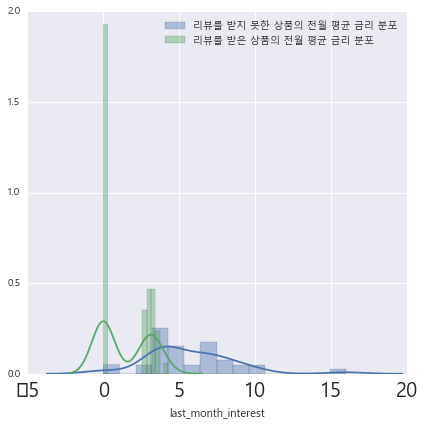

In [395]:
rent_df['reviewed'] =  rent_df['review_counts'] > 0
sns.FacetGrid(rent_df, hue = 'reviewed',size = 6).map(sns.distplot,'last_month_interest',bins = 15)
L=plt.legend()
L.get_texts()[0].set_text(u'리뷰를 받지 못한 상품의 전월 평균 금리 분포')
L.get_texts()[1].set_text(u'리뷰를 받은 상품의 전월 평균 금리 분포')


In [9]:
representative = tuple(rent_df.groupby('company').first()['idandtype'])#각각의 기업별 상품의 id가 하나씩 선택된 tuple
rent_reviews = pd.read_sql('select * from reviews where idandtype in {} '.format(representative),engine)
rent_com = rent_df.groupby('company').first()[['idandtype','review_counts']].reset_index()
rent_reviews = pd.merge(rent_com,rent_reviews,on = 'idandtype')

* 리뷰가 5개이상 달린 상품 중 KEB하나 은행의 경우 서비스 만족도와 온라인 편의에서 가장 낮은 점수를 받아 가장 낮은 총점을 기록하였다.

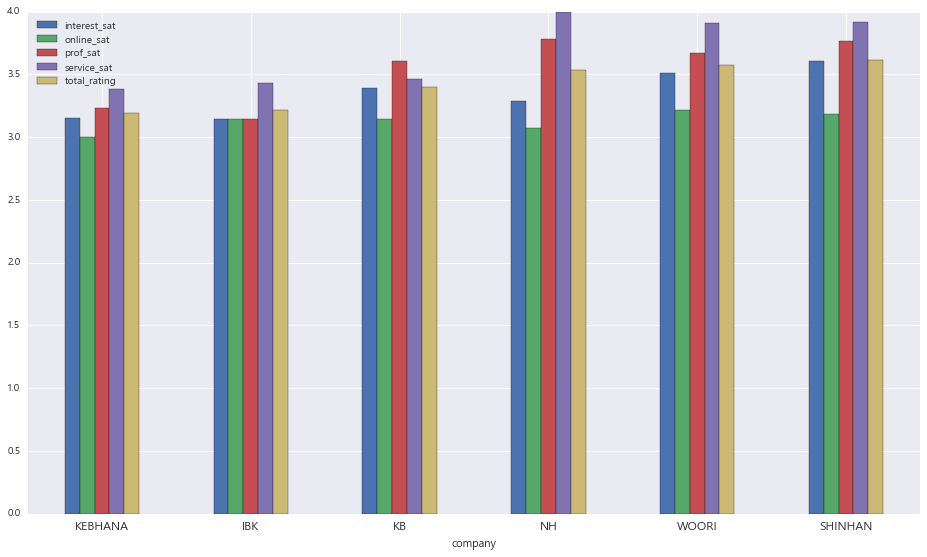

In [406]:
rent_reviews['company'] = rent_reviews['company'].apply(lambda x: x.upper())
rent_reviews[rent_reviews.review_counts > 5].groupby('company').mean().sort_values('total_rating')[['interest_sat','online_sat','prof_sat','service_sat','total_rating']].plot(kind = 'bar',figsize = (16,9),style = True)
plt.xticks(fontsize = 12,rotation = 0)
plt.legend(loc = 2)

* 실제 하나은행의 상품 중 직원들에게 받은 서비스에 대한 불만을 나타내는 리뷰가 30% 가량 나타났다.  

In [420]:
keb = rent_reviews[(rent_reviews.company == 'KEBHANA') & (rent_reviews.online_sat < 3)]
print '상담의 불만을 나타낸 댓글의 비율',float(len(keb)) / len(rent_reviews[rent_reviews.company == 'KEBHANA']),'\n' 
for kebreview,online_sat in zip(keb['review'],keb['online_sat']):
    print '온라인편의성 평점:',online_sat,'\n','댓글 내용:',kebreview,'\n'

상담의 불만을 나타낸 댓글의 비율 0.307692307692 

온라인편의성 평점: 1 
댓글 내용: 금리도 나쁘지않았지만 담당자가 신입이라 질문에대한 답변을 듣기가 오래걸려 짜증났음 

온라인편의성 평점: 2 
댓글 내용: 전세 재계약 시점에 기존에 받았던 타 은행 대출이자가 부담이 되어서 인터넷을 통해 전세대출 이자를 비교해보았습니다.

제 여건에는 주거래 은행보다 하나은행에서 금리우대조건을 받는 것이 유리한 것 같아서 약속을 잡고 하나은행에 방문하였습니다. 하나은행은 처음 거래였는데 담당 직원이 두가지 상품에 대해 소개를 해주었고 그 중 저에게 알맞는 상품을 추천해주었습니다. 저 역시도 마음에 들어 해당 전세대출 상품으로 대출을 진행하였고 다행이 원하는 금리보다 낮게, 또 필요한 만큼의 대출을 받을 수가 있었습니다.

담당 직원이 보증료 및 금리 우대에 필요한 부분과 중도상환에 대해 친절히 설명을 해줘서 꽤 만족하였고 주변에도 추천을 해주었습니다. 다만 불필요한 상품 가입을 많이 권하시는 점은 약간 부담스럽고 불편하였습니다^^;; 

온라인편의성 평점: 1 
댓글 내용: 서울로 이사오면서 급하게 대출받게 되었는데 너무 불친절했습니다. 금액이 너무 적어서 그런가요... 불친절하고 대출금액나오는날 갑자기 안된다고 해서 저희 정말 집없이 밖에 버려질 뻔 했습니다... 국가 sh 관련 상품이었지만 금리 낮은 것 빼고는 너무 마음을 졸여서 힘들었습니다. 다신 하나은행 사용하고 싶지 않아요 

온라인편의성 평점: 2 
댓글 내용: 지난 달 하나은행을 통해서 전세자금 대출을 받았습니다. 물론 주거래 은행이기 때문에 이용했구요. 계약일이 다가와서 타 금융기관과 비교를 못했던 점이 아쉬웠습니다. 해당은행에서는 금리가 가장 낮은 상품이라고 하였습니다. 하지만 직장동료를 통해서 비슷한 조건인데도 불구하고 제가 받은 금리보다 낮은 대출상품에 조금 허망한 기분이 들었네요. 다음 대출시에는 꼭 금융상품을 비교해봐야겠다는 생각이 들었습니다. 

